In [3]:
import os.path
from os import path
import requests
import tarfile
import shutil

In [4]:
PATH_TO_RESOURCES = "../resources"

## Récupération des ressources

**param force** : 1 si l'on veut télécharger la donnée m

1. Controlle l'existence d'un dossier de **resources** situé à la racine du projet
2. Si ce dossier existe et que **force == 0** alors il n'y a rien à faire
3. Sinon, le dossier est crée, l'archive est téléchargée et décompréssée puis supprimée.

In [5]:
# Check if a local resources file exists.
# If not or force=True, creates the files and uploads data.
def init_resources(force = False):
    PATH_TO_RESOURCES = "../resources"
    
    if (path.exists(PATH_TO_RESOURCES) and path.isdir(PATH_TO_RESOURCES)):
        if not force:
            print("Folder 'resources' found.")
            return
        else:
            shutil.rmtree(PATH_TO_RESOURCES)
    
    # Create folder
    os.mkdir(PATH_TO_RESOURCES)
    print("[1/4] Folder '../resources' created.")
    
    # Download data
    url_data = 'https://www.lrde.epita.fr/~jchazalo/SHARE/dobble-symbols-dataset-train.tar.gz'
    url_dobble_img = 'https://boardgamereview.co.uk/wp-content/uploads/2020/02/Dobble-cards-pile-1.png'
    TAR_PATH = os.path.join(PATH_TO_RESOURCES, 'dobble-symbols-dataset-train.tar.gz')
    IMG_PATH = os.path.join(PATH_TO_RESOURCES, 'dobble_ref.png')
    response = requests.get(url_data, stream=True)
    if response.status_code == 200:
        with open(TAR_PATH, 'wb') as f:
            f.write(response.raw.read())
    response = requests.get(url_dobble_img, stream=True)
    if response.status_code == 200:
        with open(IMG_PATH, 'wb') as f:
            f.write(response.raw.read())
            print("[2/4] Resources files uploaded.")
    
    # Extract from tar
    tar = tarfile.open(TAR_PATH)
    tar.extractall(PATH_TO_RESOURCES) # specify which folder to extract to
    tar.close()
    print("[3/4] Resources files extracted.")
    
    # Delete dowloaded tar
    os.remove(TAR_PATH)
    print("[4/4] Tarball removed.")

In [6]:
init_resources(0)

Folder 'resources' found.


# Transformateurs

## Extraction de la zone d'intérêt
1. Récupération des données d'entrainement
2. Calcul des masques
3. Extraction des pixels à utiliser dans chaque image

### Explications

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [8]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

In [9]:
# define a function to compute the mask of a bubble
def symbol2mask(symbol):
    return np.sum(symbol, axis=2) < 255 * 3

In [10]:
symbol_files = !ls $PATH_TO_RESOURCES/**/c*.png  | sort
symbol_files

['../resources/train/01/c01_s00.png',
 '../resources/train/01/c04_s01.png',
 '../resources/train/01/c07_s03.png',
 '../resources/train/01/c30_s03.png',
 '../resources/train/01/c34_s03.png',
 '../resources/train/02/c01_s01.png',
 '../resources/train/02/c09_s00.png',
 '../resources/train/02/c14_s05.png',
 '../resources/train/02/c32_s00.png',
 '../resources/train/02/c53_s03.png',
 '../resources/train/03/c03_s04.png',
 '../resources/train/03/c37_s00.png',
 '../resources/train/03/c47_s00.png',
 '../resources/train/03/c50_s01.png',
 '../resources/train/03/c51_s01.png',
 '../resources/train/04/c01_s03.png',
 '../resources/train/04/c22_s05.png',
 '../resources/train/04/c31_s02.png',
 '../resources/train/04/c39_s02.png',
 '../resources/train/04/c46_s04.png',
 '../resources/train/05/c01_s04.png',
 '../resources/train/05/c12_s07.png',
 '../resources/train/05/c23_s01.png',
 '../resources/train/05/c29_s02.png',
 '../resources/train/05/c38_s03.png',
 '../resources/train/06/c01_s05.png',
 '../resourc

In [11]:
symbols = [load_image(symbol_file) for symbol_file in symbol_files]

In [12]:
symbols_masks = [symbol2mask(symbol) for symbol in symbols]

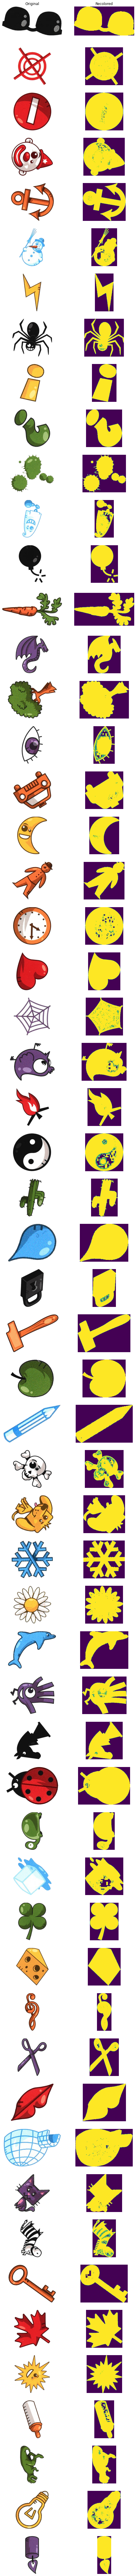

In [13]:
plt.figure(figsize=(8,16 * 10))
for ii in range(57):
    plt.subplot(57,2,1+2*ii)
    plt.imshow(symbols[ii * 5])
    plt.axis("off")
    if ii == 0:
        plt.title("Original")
    plt.subplot(57,2,2+2*ii)
    plt.imshow(symbols_masks[ii * 5])
    plt.axis("off")
    if ii == 0:
        plt.title("Recolored")

### Etape de pipeline

In [14]:
class SymbolExtractor():
    def __init__(self):
        self.masks = []
        
    def fit(self, X, y=None, sample_weight=None):
        for symbol in X:
            self.masks.append(np.sum(symbol, axis=2) < 255 * 3)
        
        return self
    
    def transform(self, X, copy=None):
        return [X[i][self.masks[i]] for i in range(len(X))]

## Réduction des couleurs
Les images sont composées de nombreuses  nuances de couleurs qui ne sont pas forcément nécessaires. On va donc chercher à réduire le nombre couleurs différentes.

### Explications

In [15]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [16]:
sample_pixels = symbols[0][symbols_masks[0]]
for i in range(1, len(symbols)):
    sample_pixels = np.concatenate((sample_pixels, symbols[i][symbols_masks[i]]), axis=0)

sample_pixels.shape, sample_pixels.dtype

((5848412, 3), dtype('uint8'))

In [17]:
def find_and_plot_cluster_centers(clusters_nb):
    # Train kmeans
    kmeans = MiniBatchKMeans(clusters_nb, random_state=42)
    kmeans.fit(sample_pixels)
    
    # Create the LUT
    color_lut = np.uint8(kmeans.cluster_centers_)
    
    # Sort it by hue
    hue_lut = cv2.cvtColor(color_lut.reshape(1,color_lut.shape[0], color_lut.shape[1]), cv2.COLOR_BGR2HSV)[:, :, 0]
    indices = hue_lut.argsort(axis=None)
    color_lut_sorted = color_lut[indices]
    
    # Plot it
    plt.bar(np.arange(len(color_lut)), 
        np.ones(len(color_lut)), 
        color=color_lut_sorted/255)
    
    return kmeans, color_lut

CPU times: user 27min 24s, sys: 30.3 s, total: 27min 54s
Wall time: 4min 21s


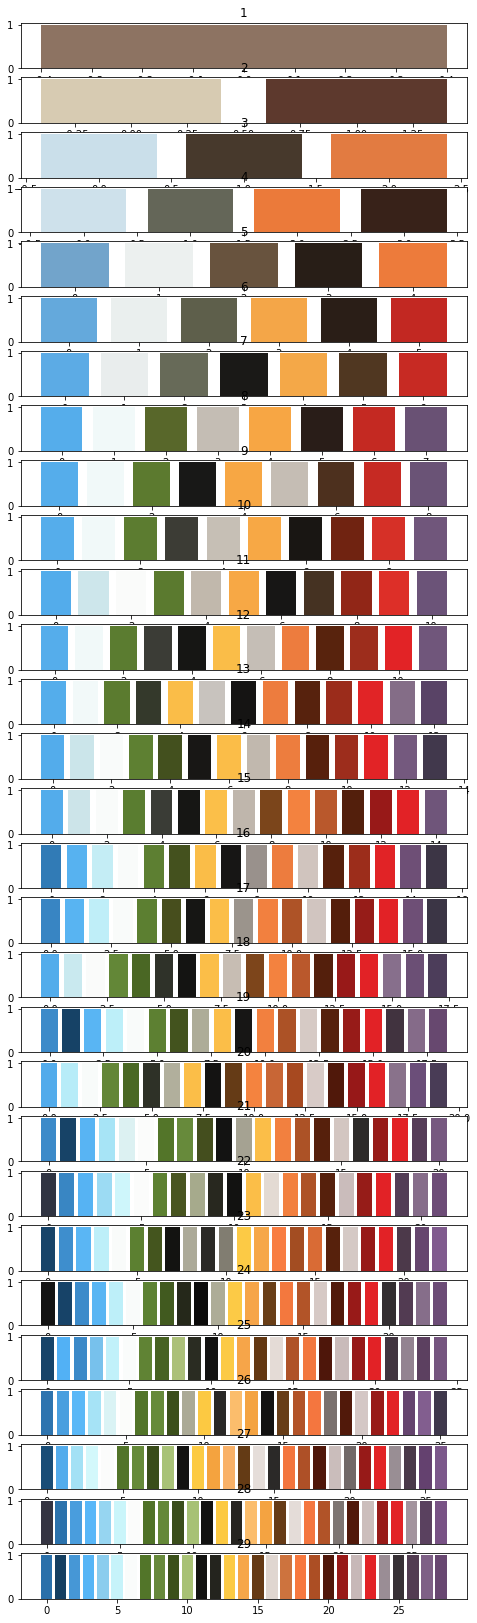

In [53]:
%%time
# let us display the images
plt.figure(figsize=(8,30))
max_clusters_nb = 15
variances = np.zeros(max_clusters_nb - 1)

for ii in range(1, max_clusters_nb):
    plt.subplot(max_clusters_nb, 1, ii)
    
    kmeans, color_lut = find_and_plot_cluster_centers(ii)
    plt.title(ii)
    
    variances[ii - 1] = kmeans.inertia_

In [18]:
from matplotlib.ticker import MaxNLocator

In [19]:
plt.plot(np.arange(1, max_clusters_nb), variances)
plt.xlabel("Number of clusters")
plt.ylabel("Variance")
plt.title("Variance in function of the number of clusters")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

NameError: name 'max_clusters_nb' is not defined

6 clusters semble être un bon choix.

Vérifions cette supposition.

In [20]:
def recolor_masked_know(symbol, symbol_mask, clusterer, color_lut):
    recolored = np.ones_like(symbol) * 255
    recolored[symbol_mask] = color_lut[np.uint8(clusterer.predict(symbol[symbol_mask]))]
    return recolored

CPU times: user 44.5 s, sys: 830 ms, total: 45.3 s
Wall time: 7.46 s


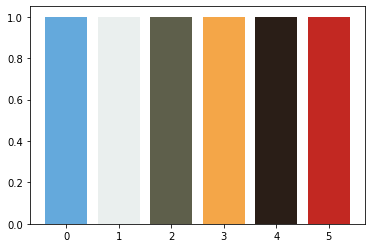

In [21]:
%%time
# reduce the color of all bubbles
# This is exactly what we did for the full poster, but applied to each bubble AND keeping background as black.
kmeans, color_lut = find_and_plot_cluster_centers(6)
symbols_quant = [recolor_masked_know(symbols[i], symbols_masks[i], kmeans, color_lut) for i in range(len(symbols))]

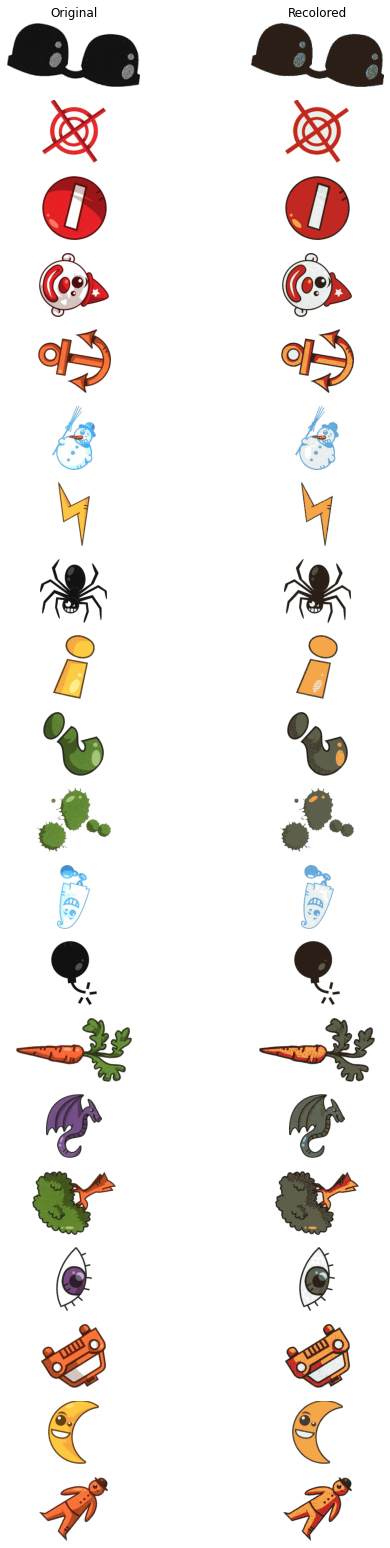

In [22]:
# let us display the images
plt.figure(figsize=(8,16 * 5))
for ii in range(20):
    plt.subplot(57,2,1+2*ii)
    plt.imshow(symbols[ii * 5])
    plt.axis("off")
    if ii == 0:
        plt.title("Original")
    plt.subplot(57,2,2+2*ii)
    plt.imshow(symbols_quant[ii * 5])
    plt.axis("off")
    if ii == 0:
        plt.title("Recolored")

On peut remarquer que le vert et le violet se confondent.

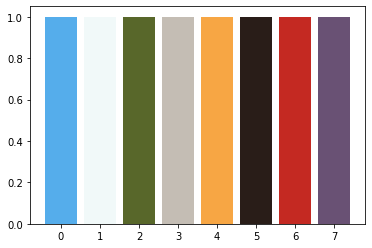

In [23]:
kmeans, color_lut = find_and_plot_cluster_centers(8)
symbols_quant = [recolor_masked_know(symbols[i], symbols_masks[i], kmeans, color_lut) for i in range(len(symbols))]

Pour 8 clusters le violet apparaît.

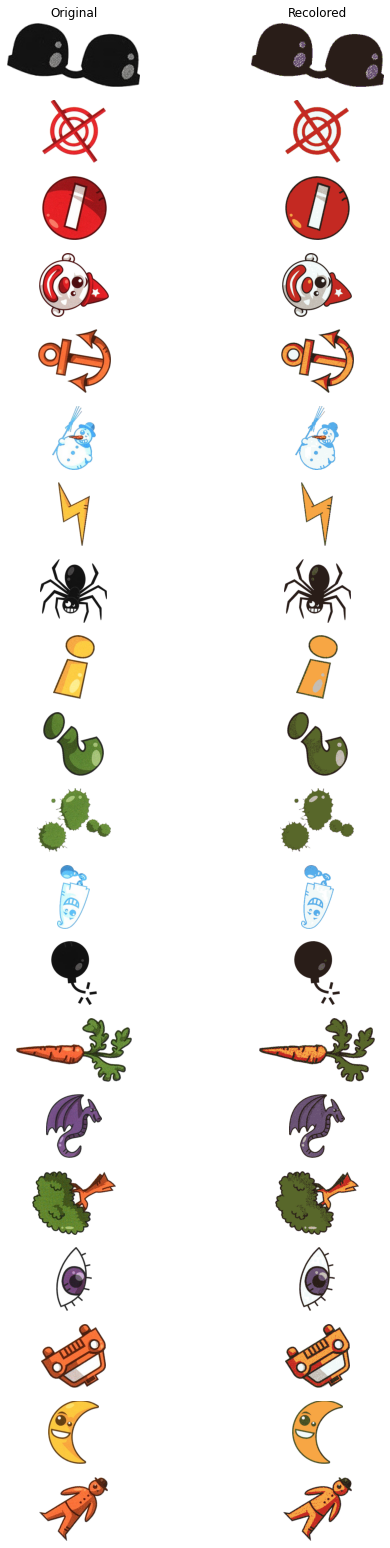

In [24]:
plt.figure(figsize=(8,16 * 5))
for ii in range(20):
    plt.subplot(57,2,1+2*ii)
    plt.imshow(symbols[ii * 5])
    plt.axis("off")
    if ii == 0:
        plt.title("Original")
    plt.subplot(57,2,2+2*ii)
    plt.imshow(symbols_quant[ii * 5])
    plt.axis("off")
    if ii == 0:
        plt.title("Recolored")

On observe des résultats plus satisfaisants qu'avec 6 clusters, on va donc en utiliser 8.

### Etape de pipeline

In [25]:
class ColorReducer():
    def __init__(self):
        self.kmeans = MiniBatchKMeans(8, random_state=1)
        self.masks = None
        self.lut = None
        
    def fit(self, X, y=None, sample_weight=None):
        self.masks = [np.sum(X[0], axis=1) < 255 * 3]
        sample_pixels = X[0][self.masks[0]]
        for i in range(1, len(X)):
            self.masks.append(np.sum(X[i], axis=1) < 255 * 3)
            sample_pixels = np.concatenate((sample_pixels, X[i][self.masks[i]]), axis=0)
        # Train kmeans
        self.kmeans.fit(sample_pixels)

        # Create the LUT
        self.lut = np.uint8(self.kmeans.cluster_centers_)
        
        return self
    
    def transform(self, X, copy=None):
        recoloreds = []
        for i in range(len(X)):
            recolored = np.ones_like(X[i]) * 255
            recolored[self.masks[i]] = self.lut[np.uint8(self.kmeans.predict(X[i]))]
            recoloreds.append(recolored)
            
        return recoloreds

# Extraction de caractéristiques

## Histogramme couleur

### Explications

In [26]:
def symbol2hist(symbol, symbol_mask, clusterer):
    return np.bincount(np.uint8(clusterer.predict(symbol[symbol_mask])), minlength = clusterer.n_clusters) / np.count_nonzero(symbol_mask)

In [27]:
color_histograms = [symbol2hist(symbols_quant[i], symbols_masks[i], kmeans) for i in range(len(symbols))]

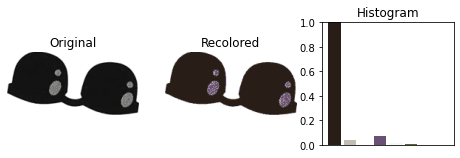

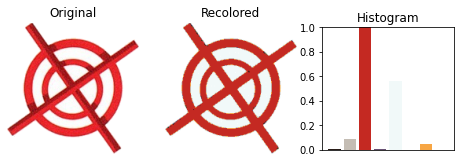

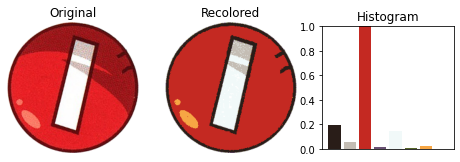

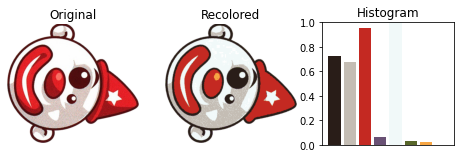

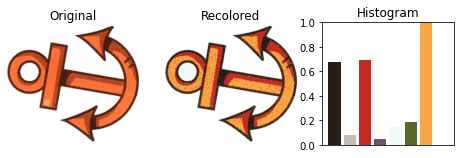

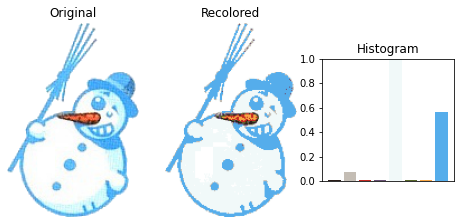

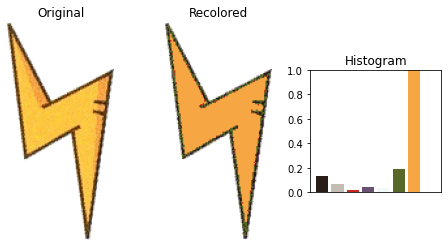

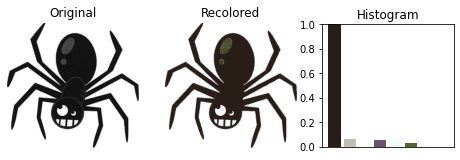

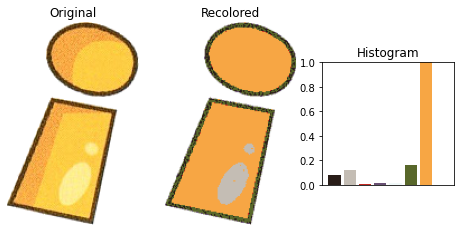

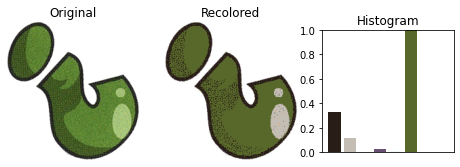

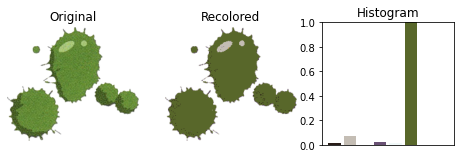

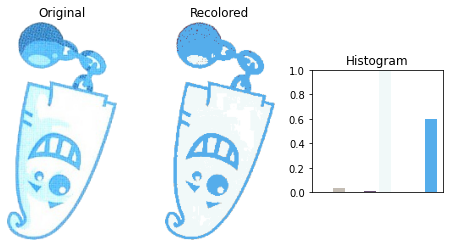

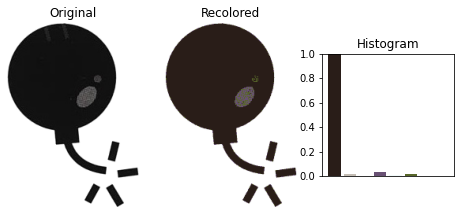

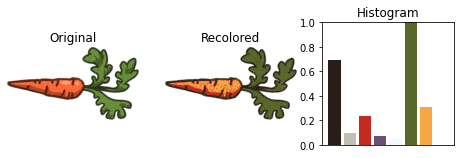

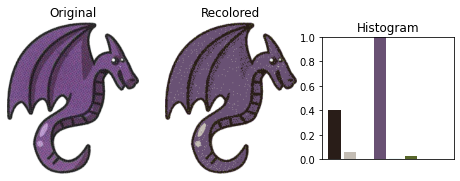

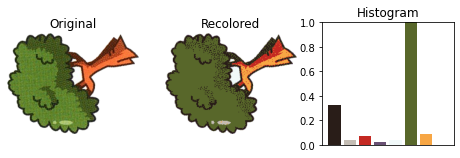

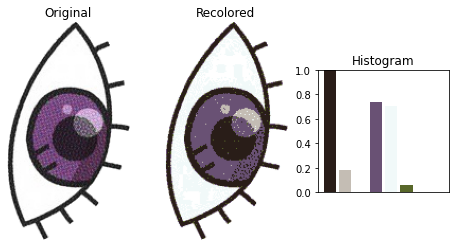

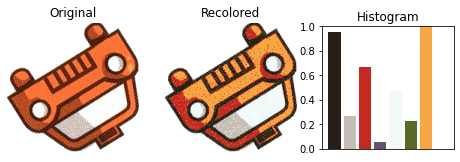

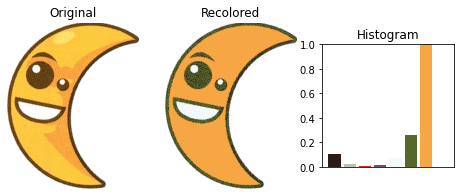

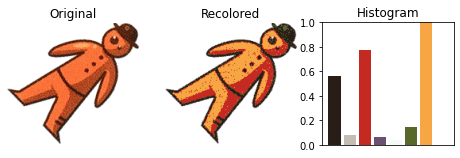

In [28]:
colors_for_bars = color_lut/255  # matplotlib colors are RGB values scaled to [0,1]
for ii in range(20):
    plt.figure(figsize=(8,4))
    plt.subplot(1,3,1)
    symbol_index = ii * 5
    plt.imshow(symbols[symbol_index])
    plt.axis('off'); plt.title("Original")
    plt.subplot(1,3,2)
    plt.imshow(symbols_quant[symbol_index])
    plt.axis('off'); plt.title("Recolored")
    plt.subplot(1,3,3, aspect=len(color_histograms[0]))
    plt.ylim(0, 1)
    plt.bar(range(len(color_histograms[symbol_index])), 
            color_histograms[symbol_index]/color_histograms[symbol_index].max(), 
            color=colors_for_bars)
    plt.xticks([]); plt.title("Histogram")
    plt.show()

### Etape de pipeline

In [29]:
class ColorHistogram():
    def __init__(self):
        self.kmeans = MiniBatchKMeans(8)
        
    def fit(self, X, y=None, sample_weight=None):
        self.masks = [np.sum(X[0], axis=1) < 255 * 3]
        sample_pixels = X[0][self.masks[0]]
        for i in range(1, len(X)):
            self.masks.append(np.sum(X[i], axis=1) < 255 * 3)
            sample_pixels = np.concatenate((sample_pixels, X[i][self.masks[i]]), axis=0)
        # Train kmeans
        self.kmeans.fit(sample_pixels)
        
        return self
    
    def transform(self, X, copy=None):
        histograms = []
        for i in range(len(X)):
            histo = np.bincount(np.uint8(self.kmeans.predict(X[i])),
                        minlength = self.kmeans.n_clusters) / np.count_nonzero(self.masks[i])
            histograms.append(histo)

        return histograms

In [30]:
import cv2
from math import copysign, log10

# Classifieurs

In [32]:
import re

In [33]:
symbols_labels = np.array([re.search(".+/([0-9]{2})/.+\.png", symbol_file).group(1) for symbol_file in symbol_files])

In [34]:
pipeline_transformers = [("extraction", SymbolExtractor()), ("color reduction", ColorReducer())]

## Classifieur: Dummy classifier

### Démonstration

In [35]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline

In [36]:
dummy_clf  = DummyClassifier()
dummy_clf.fit(color_histograms, symbols_labels)
dummy_clf.predict(color_histograms)

steps = pipeline_transformers + [("color histogram", ColorHistogram()), ("dummy clf", DummyClassifier())]
dummy_pipeline = Pipeline(steps, verbose=True)
dummy_pipeline.fit(symbols, symbols_labels)
dummy_pipeline.score(symbols, symbols_labels)

[Pipeline] ........ (step 1 of 4) Processing extraction, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing color reduction, total=  21.7s
[Pipeline] ... (step 3 of 4) Processing color histogram, total=   2.1s
[Pipeline] ......... (step 4 of 4) Processing dummy clf, total=   0.0s


0.017543859649122806

In [37]:
from sklearn.svm import LinearSVC

In [ ]:
steps = pipeline_transformers + [("color histogram", ColorHistogram()), ("LinearSVC clf", LinearSVC())]
linear_svc_pipeline = Pipeline(steps, verbose=True)
linear_svc_pipeline.fit(symbols, symbols_labels)
linear_svc_pipeline.score(symbols, symbols_labels)

In [40]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
steps = pipeline_transformers + [("color histogram", ColorHistogram()), ("KNeighbours clf", KNeighborsClassifier())]
kneighbors_pipeline = Pipeline(steps, verbose=True)
kneighbors_pipeline.fit(symbols, symbols_labels)
kneighbors_pipeline.score(symbols, symbols_labels)

In [41]:
from sklearn.svm import SVC

In [ ]:
steps = pipeline_transformers + [("color histogram", ColorHistogram()), ("SVC clf", SVC())]
kneighbors_pipeline = Pipeline(steps, verbose=True)
kneighbors_pipeline.fit(symbols, symbols_labels)
kneighbors_pipeline.score(symbols, symbols_labels)

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
steps = pipeline_transformers + [("color histogram", ColorHistogram()), ("Random Forest clf", RandomForestClassifier())]
kneighbors_pipeline = Pipeline(steps, verbose=True)
kneighbors_pipeline.fit(symbols, symbols_labels)
kneighbors_pipeline.score(symbols, symbols_labels)

# Benchmark

In [43]:
extractors = [("color histogram", ColorHistogram())]

In [44]:
classifiers = [
    ("dummy clf", DummyClassifier()),
    ("LinearSVC clf", LinearSVC()),
    ("KNeighbours clf", KNeighborsClassifier()),
    ("SVC clf", SVC()),
    ("Random Forest clf", RandomForestClassifier()),
]

In [45]:
import time

In [46]:
nb_tests = len(extractors) * len(classifiers)
benchmark = []
for i in range(len(extractors)):
    for j in range(len(classifiers)):
        steps = pipeline_transformers + [extractors[i], classifiers[j]]
        pipeline = Pipeline(steps)
        
        start = time.process_time()
        pipeline.fit(symbols, symbols_labels)
        fit_time = time.process_time() - start
        
        start = time.process_time()
        # TODO replace symbols with test set to score
        score = pipeline.score(symbols, symbols_labels)
        score_time = time.process_time() - start
        benchmark.append((extractors[i][0],
                          classifiers[j][0],
                          "{:.3f} %".format(score),
                          "{:.3f} s".format(fit_time),
                          "{:.3f} s".format(score_time)))

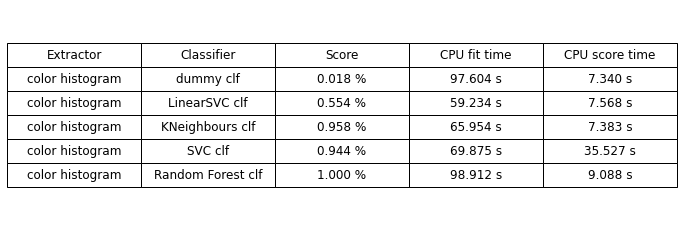

In [47]:
fig, ax =plt.subplots()
column_labels=["Extractor", "Classifier", "Score", "CPU fit time", "CPU score time"]
ax.axis("tight")
ax.axis("off")
table = ax.table(cellText=benchmark,
                 colLabels=column_labels,
                 loc="center",
                 cellLoc="center")

table.set_fontsize(20)
table.scale(2, 2)

plt.show()